In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import DataSplitter

In [12]:
df60 = DataSplitter.getTrainData(60)

# Input diff, output diff
#target_column = "diff"
#drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "passengersBoarding", "datetime", "eventName"]

# Input diff, output passengers
target_column = "passengersBoarding"
drop_cols = ["date", "hour", "year", "quarter", "Q1", "month", "monthNumber", "weekNumber", "weekDay", "dateNumber", "mon", "workdayPlan", "line", "diff", "datetime", "eventName"]

train60, val60 = DataSplitter.performTrainValSplit(df60)
train60_1A = train60[train60["line"] == "1A"]
val60_1A = val60[val60["line"] == "1A"]

X_train = train60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
X_val = val60_1A.drop(columns=([target_column] + drop_cols), axis=1).reset_index(drop=True)
y_train = train60_1A[target_column].reset_index(drop=True)
y_val = val60_1A[target_column].reset_index(drop=True)

In [13]:
batchSize = 32  # len(X_train)//20

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled).squeeze(-1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled).squeeze(-1)

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=False)

valDataset = TensorDataset(X_val_tensor, y_val_tensor)
valLoader = DataLoader(valDataset, batch_size=batchSize, shuffle=False)

In [14]:
def evaluation(model, loader, criterion, device):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for batch_idx, (Xbatch, ybatch) in enumerate(loader):
            Xbatch = Xbatch.to(device)
            ybatch = ybatch.to(device)
                
            predictions = model(Xbatch.unsqueeze(-1)).squeeze()

            loss = criterion(predictions, ybatch)
            total_loss.append(loss.item())
    return np.mean(total_loss)

In [15]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=4, output_size=1, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

cuda


In [16]:
model = LSTM().to(device)
totalEpochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="mean")

train_loss_list = []
val_loss_list = []
nEpochs = range(1, totalEpochs + 1)
for epoch in nEpochs:
    model.train()
    total_loss = []
    for batch_idx, (Xbatch, ybatch) in enumerate(trainLoader):
        optimizer.zero_grad()

        Xbatch = Xbatch.to(device)
        ybatch = ybatch.to(device)

        predictions = model(Xbatch.unsqueeze(-1)).squeeze()

        loss = criterion(predictions, ybatch)
            
        loss.backward()

        optimizer.step()

        total_loss.append(loss.item())

    val_loss_mean = evaluation(model, valLoader, criterion, device)

    total_loss_mean = np.mean(total_loss)
    train_loss_list.append(total_loss_mean)
    val_loss_list.append(val_loss_mean)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Train Loss: {total_loss_mean}, Val Loss: {val_loss_mean}")

train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
#np.save(train_loss_list, "train_loss.npy")
#np.save(val_loss_list, "val_loss.npy")
model = model.to("cpu")

Epoch: 10, Train Loss: 0.0947945594974268, Val Loss: 0.11253230443930831
Epoch: 20, Train Loss: 0.0663047877276288, Val Loss: 0.09475462340974602
Epoch: 30, Train Loss: 0.052094966146794666, Val Loss: 0.07737385221467964
Epoch: 40, Train Loss: 0.04374192813756289, Val Loss: 0.07548308796409903
Epoch: 50, Train Loss: 0.04031620771382694, Val Loss: 0.06834979788881951
Epoch: 60, Train Loss: 0.035447103021086106, Val Loss: 0.06435668171415555
Epoch: 70, Train Loss: 0.03228290720329435, Val Loss: 0.06903735657447371
Epoch: 80, Train Loss: 0.028628432482058964, Val Loss: 0.06346274457936144
Epoch: 90, Train Loss: 0.0256835323330299, Val Loss: 0.06469915646674304
Epoch: 100, Train Loss: 0.023585863586937227, Val Loss: 0.06506817689936223


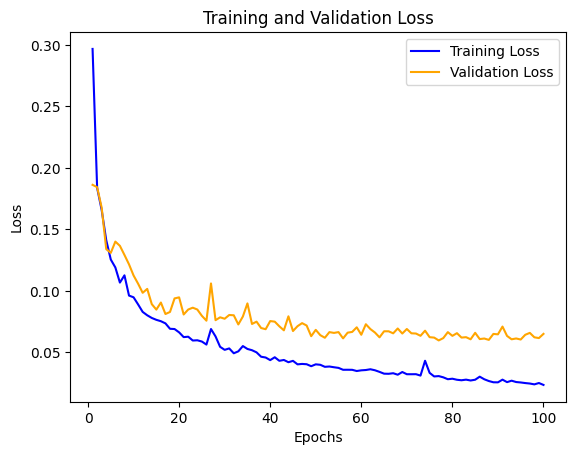

In [17]:
import matplotlib.pyplot as plt

plt.plot(nEpochs, train_loss_list, "blue", label="Training Loss")
plt.plot(nEpochs, val_loss_list, "orange", label="Validation Loss")

#plt.xlim(500, 1000)
#plt.ylim(0.05, 0.35)

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

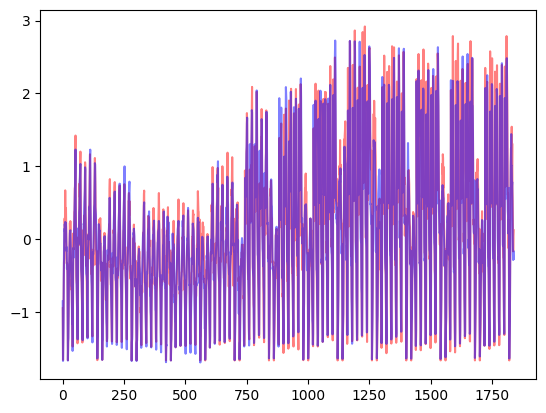

In [18]:
y_val_pred_scaled = pd.Series(model(X_val_tensor.unsqueeze(-1)).squeeze().detach())
y_val_pred = pd.Series(scaler_y.inverse_transform(model(X_val_tensor.unsqueeze(-1)).detach()).squeeze())

plt.plot(y_val_scaled, color="red", alpha=0.5)
plt.plot(y_val_pred_scaled, color="blue", alpha=0.5)

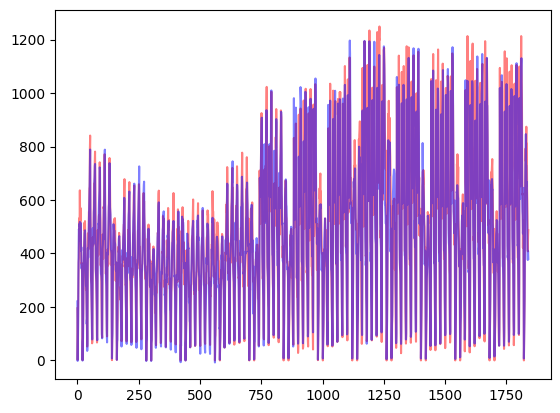

In [19]:
plt.plot(y_val, color="red", alpha=0.5)
plt.plot(y_val_pred, color="blue", alpha=0.5)

In [11]:
period = 40
val60_line_extended = pd.concat([train60_1A['passengersBoarding'].tail(period), val60_1A['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_1A['diff'].tail(period), y_val_pred], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

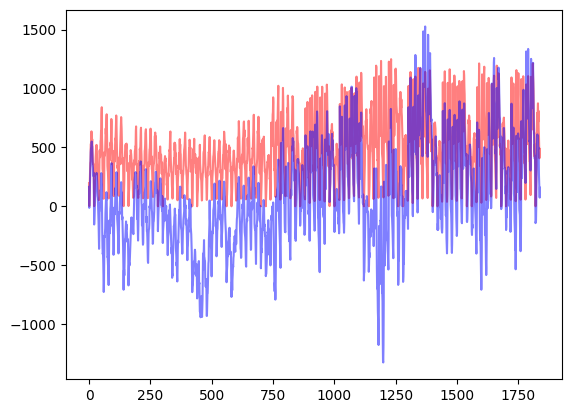

In [13]:
plt.plot(val60_1A["passengersBoarding"].reset_index(drop=True), color="red", alpha=0.5)
plt.plot(y_val_pred_passengers.reset_index(drop=True), color="blue", alpha=0.5)

In [20]:
from utils import MAE, MAPE, RMSE
print("MAE%:", MAE(y_val, y_val_pred))
print("MAPE:", MAPE(y_val, y_val_pred))
print("RMSE%:", RMSE(y_val, y_val_pred))

MAE%: 0.108
MAPE: 0.144
RMSE%: 0.149


## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM